# Datenaufbereitung
Es werden Daten geladen und aufbereitet, näheres dazu lässt sich in der Arbeit lesen

#### Allgemeines Setup des Notebooks

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pandas import read_csv
from sklearn.utils import shuffle
from datetime import datetime
from pandas.core.computation.check import NUMEXPR_INSTALLED
import seaborn as sns

### 1. Daten werden geladen und in ein Dataframe umgewandelt

In [64]:
with open('../resources/fullData.json') as dataJson:
    data = json.load(dataJson)

In [65]:
df_data = pd.DataFrame(data)
#lösche alle Sessions raus die keine session_id haben 
df = df_data[df_data['session'].notna()]
df.head()

,clientId,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width,browser,key
339,2567c85a-ad16,inputPet,824.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:24.171Z,673,363,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
340,2567c85a-ad16,inputPet,858.2999999988824,mouseout,TestEinfach,2022-10-17T13:35:24.205Z,772,333,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
341,2567c85a-ad16,inputCountry,2005.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:25.361Z,796,266,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
342,2567c85a-ad16,inputCountry,2296.5,focus,TestEinfach,2022-10-17T13:35:25.652Z,NaN,NaN,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,Chrome,NaN
343,2567c85a-ad16,inputHouse,2875.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:26.230Z,995,264,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN


### 2. Bereinigung der Daten

#### 2.1 Alle Ereignisse abrufen, die sich tatsächlich in TestSchwer befinden

In [66]:
array_input_schwer = ['inputHobby','inputCancelor','inputTemperature','inputDays','inputRiver', 'inputDifficultQuestion', 'clickHere', 'buttonYes', 'alibiClick']

df_einfach_without_schwerInput = df[~df['elementId'].isin(array_input_schwer)]
df_schwer_without_einfachInput = df[df['elementId'].isin(array_input_schwer)]

df_actually_schwer = df_einfach_without_schwerInput.loc[df_einfach_without_schwerInput['siteName'] == 'TestSchwer']
df_easy = df_actually_schwer.assign(sitename='TestSchwer')

df_einfach = df_einfach_without_schwerInput.loc[~(df_einfach_without_schwerInput['siteName'] == 'TestSchwer')]
df_schwer = pd.concat([df_easy, df_schwer_without_einfachInput])
df_schwer['siteName'] = 'TestSchwer'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

#### 2.2 Gleich viele Sessions bei TestSchwer & TestEinfach

In [67]:
sessionIdSchwer = df_schwer['session']
sessionIdEinfach = df_einfach['session']

df_einfach['is_duplicated'] = df_einfach.duplicated('session')
#89 ids auf Seite Einfach
setEinfach = set(sessionIdEinfach)
length = len(setEinfach)
print(length)

#70 ids auf Seite Schwer
df_schwer['is_duplicated'] = df_schwer.duplicated('session')
setSchwer = set(sessionIdSchwer)
lengthSchwer = len(setSchwer)
print(lengthSchwer)

89
70


<ipython-input-67-2d14dad677d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_einfach['is_duplicated'] = df_einfach.duplicated('session')


Es werden alle Sessions gelöscht die nicht auf beiden Seiten vorhanden sind

In [68]:
in_schwer_but_not_in_einfach = setSchwer - setEinfach
in_einfach_but_not_in_schwer = setEinfach - setSchwer

array_einfach = list(in_einfach_but_not_in_schwer)
array_schwer = list(in_schwer_but_not_in_einfach)

df_einfach_without_ids = df_einfach[~df_einfach['session'].isin(array_einfach)]
df_schwer_without_ids = df_schwer[~df_schwer['session'].isin(array_schwer)]

df_einfach_final = df_einfach_without_ids.drop(['clientId', 'is_duplicated'], axis=1)
df_schwer_final = df_schwer_without_ids.drop(['clientId', 'is_duplicated'], axis=1)

print("Anzahl der Session-Ids bei einfach", 89 - len(array_einfach))
print("Anzahl der Session-Ids bei schwer",70 - len(array_schwer))

Anzahl der Session-Ids bei einfach 66
Anzahl der Session-Ids bei schwer 66


Hier wird die jeweilige Anzahl der Seiten betrachtet. 

In [69]:
df_concat_data = pd.concat([df_schwer_final, df_einfach_final])
df_concat_data['session'].value_counts()
print('Anzahl der Events:',len(df_concat_data))

Anzahl der Events: 35164


In [70]:
print(df_einfach_final['session'].value_counts())
print('Anzahl der Events von TestSchwer:',len(df_einfach_final))

69e36b9c-46ec-e499-4a8c-9590b2ca8695    595
6c81bd46-f25a-08fe-9f88-6652cefdf249    275
ea50816c-8d4f-5629-a078-c048513d4fd6    253
2e506528-adcc-8870-92ab-5c8d36f84add    226
849db5c6-9138-0fdc-1a4b-86e89ab9acd3    214
                                       ... 
efb4f373-decb-6b63-194f-b7acb93cf94d     18
bbf7e1d0-6d9a-2025-fce7-45a86117014a     16
fd6c4243-c30d-f1ff-f22e-c2f56b2cf901     14
a42e916e-1d9b-51f0-19ed-f4262b0d1c70     10
da1c188a-f46a-25bf-af34-c8e3afa30304      2
Name: session, Length: 66, dtype: int64
Anzahl der Events von TestSchwer: 4086


In [71]:
print(df_schwer_final['session'].value_counts())
print('Anzahl der Events von TestSchwer:',len(df_schwer_final))

2e506528-adcc-8870-92ab-5c8d36f84add    4338
b721640b-042e-77a9-9864-28c0ce5264fb    2780
6c81bd46-f25a-08fe-9f88-6652cefdf249    2263
69e4a6b4-0c82-f9be-c9d2-ea959fb5ac90    1678
90ab4d9b-1f2b-12d8-0607-da60d299f472    1591
                                        ... 
bbf7e1d0-6d9a-2025-fce7-45a86117014a       9
da1c188a-f46a-25bf-af34-c8e3afa30304       7
a2182a9f-b55f-ad7c-0744-9c3106331d5d       6
24027ad1-57b0-1b05-d2b4-55d6d4e1bf65       5
35e42b1c-1ae0-9ab7-b1cb-9bc03f17b034       4
Name: session, Length: 66, dtype: int64
Anzahl der Events von TestSchwer: 31078


#### 2.3 Diskrepanz der Daten analysieren

Text(0.5, 1.0, 'Count for Events')

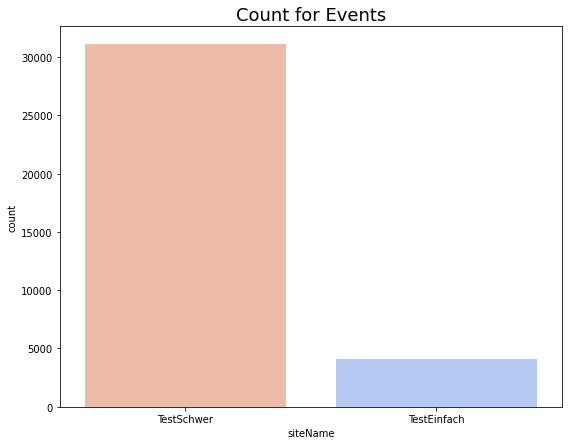

In [72]:
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'siteName', data = df_concat_data, palette="coolwarm_r")
# Add title
plt.title('Count for Events', fontsize=18)

<AxesSubplot: xlabel='type', ylabel='count'>

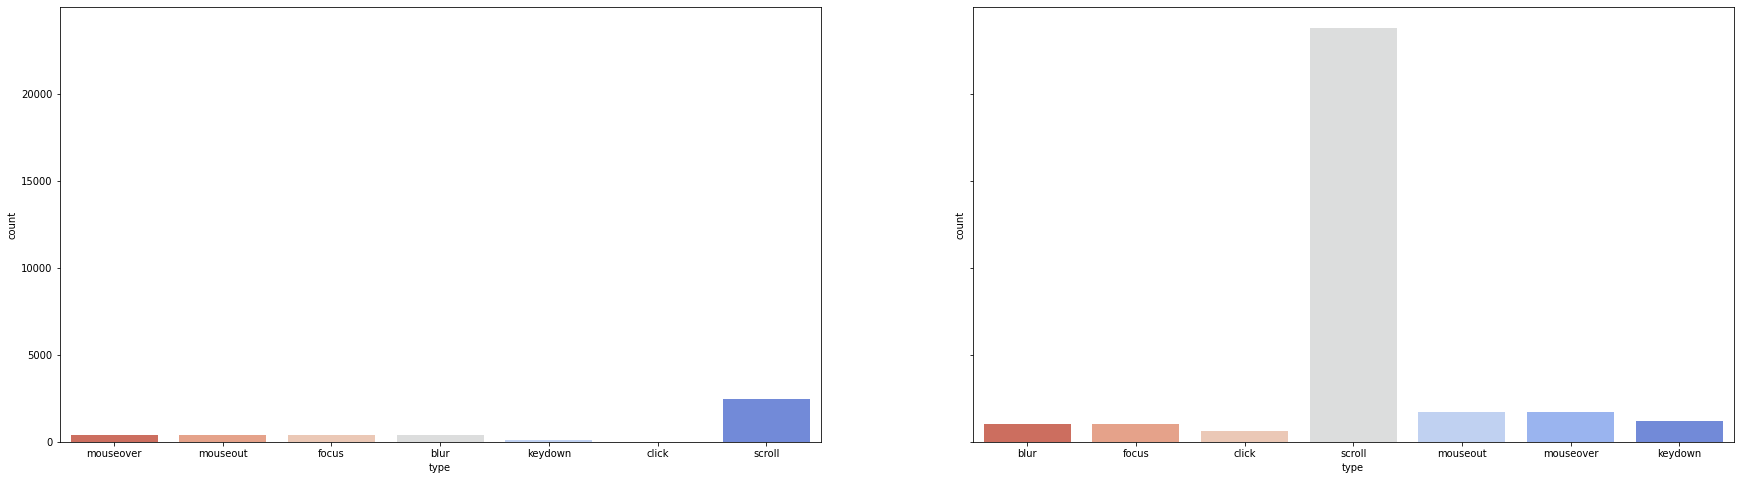

In [73]:
fig2, axs2 = plt.subplots(1,2, figsize=(30,8), sharey=True)

# Count plot
sns.countplot(x = 'type', data = df_einfach_final, palette="coolwarm_r", ax=axs2[0])
sns.countplot(x = 'type', data = df_schwer_final, palette="coolwarm_r", ax=axs2[1])

Dadurch, dass der scroll-type viele Events enthält, kaum auf der einfachen Seite vertreten ist und der Datensatz ungleichmäßig verteilt, wird der scroll-type gelöscht

In [74]:
df_einfach_final = df_einfach_final.loc[df_einfach_final["type"] !="scroll"]
df_schwer_final = df_schwer_final.loc[df_schwer_final["type"] !="scroll"]

In [75]:
print('Anzahl der Events ohne Scroll von TestEinfach:',len(df_einfach_final))
print('Anzahl der Events ohne Scroll von TestSchwer:',len(df_schwer_final))

Anzahl der Events ohne Scroll von TestEinfach: 1603
Anzahl der Events ohne Scroll von TestSchwer: 7279


#### 2.4 Werte in float umwandeln

In [76]:
array_of_properties = ['timeStamp', 'clientX', 'clientY', 'height', 'width']

In [77]:
def toFloat(test, array):
    for x in range(5): 
        test[array[x]] = test[array[x]].astype(float)
    test['date'] = test['date'].astype('datetime64[ns]')

toFloat(df_einfach_final, array_of_properties)
toFloat(df_schwer_final, array_of_properties)

#### 2.5 Fehlende Werte analysieren und entfernen

In der Grafik werden die fehlenden Werte visualisiert. Wenn ein Wert fehlt wird er auf 'True' gesetzt, falls nicht wird er auf 'False' gesetzt. 

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

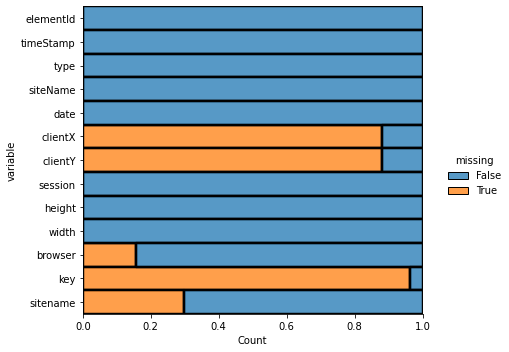

In [78]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df_concat_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [79]:
#löschen der key & browser Spalte
df_einfach_final = df_einfach_final.drop(['key', 'browser'], axis=1)
df_schwer_final = df_schwer_final.drop(['key', 'browser', 'sitename'], axis=1)

Es wird der Median für clienX & clientX gesetzt.

In [80]:
df_einfach_final['clientX'].fillna((df_einfach_final['clientX'].mean()), inplace=True)
df_einfach_final['clientY'].fillna((df_einfach_final['clientY'].mean()), inplace=True)

df_schwer_final['clientX'].fillna((df_schwer_final['clientX'].mean()), inplace=True)
df_schwer_final['clientY'].fillna((df_schwer_final['clientY'].mean()), inplace=True)

In [81]:
df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

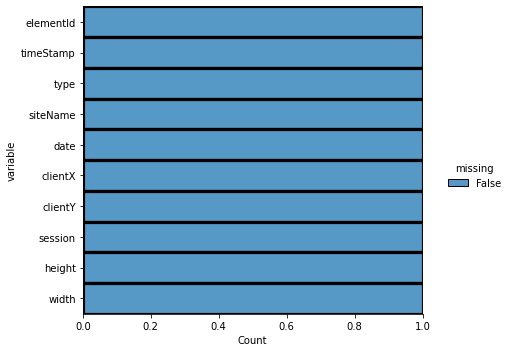

In [82]:
#test if something is missing 
plt.figure(figsize=(10,6))
sns.displot(
    data=df_concat_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [83]:
#Setze numerische Werte für die Spalte 'siteName'
df_einfach_final['siteName'] = 0
df_schwer_final['siteName'] = 1

df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

Es werden alle Werte gelöscht die eine höhere Duration von 3000000 haben

In [84]:
df_schwer_final = df_schwer_final.loc[(df_schwer_final['timeStamp'] < 3000000)]

#### 2.6 Neue Ids

Hier werden neue Ids vergeben, damit jede Session unabhängig voneinander behandelt werden kann. Dafür wird ihr eine dreistellige Zahl zugeteilt. 

In [85]:
# new sessionId 
import random
from random import choice
import collections

array_of_ids_einfach = df_einfach_final['session'].value_counts().index.tolist()
array_of_ids_schwer = df_schwer_final['session'].value_counts().index.tolist()
numbers_schwer = []

random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
for i in range(len(random_numbers_ids_einfach)):
    random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
    numbers_schwer.append(random_numbers_ids_schwer)

numbers = random_numbers_ids_einfach + numbers_schwer

df_einfach_final['session'] = df_einfach_final['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
df_schwer_final['session'] = df_schwer_final['session'].replace(array_of_ids_schwer, numbers_schwer)

Zu diesem Zeitpunkt wurde dann die bereinigten Daten in ein pickle umgewandelt, damit dieses auch in anderen Files verwendet werden kann und sich nicht dauernd die Ids verändern. 
Der Command dazu lautet:
df_concat_data = pd.read_pickle('CleanedDataWithIds.pkl')

### 2.7 Analyse des Parameters 'windows'

In [86]:
#Laden der bereinigten Daten
df_concat_data = pd.read_pickle('../resources/CleanedDataWithIds.pkl')

#Extraction in zwei Dataframes
df_einfach_final = df_concat_data.loc[df_concat_data['siteName'] == 0]
df_schwer_final = df_concat_data.loc[df_concat_data['siteName'] == 1]

In [87]:
df_einfach_final['type'].value_counts()

mouseover    380
mouseout     379
blur         375
focus        374
keydown       91
click          4
Name: type, dtype: int64

In [88]:
df_schwer_final['type'].value_counts()

mouseover    1698
mouseout     1688
keydown      1219
blur         1024
focus         997
click         618
Name: type, dtype: int64

In [89]:
df_blur = df_schwer_final.loc[(df_schwer_final['elementId'] == 'window') & (df_schwer_final['type'] == 'blur')]
print('Anzahl der blur Elemente mit window als elementId auf der schweren Seite:',len(df_blur['elementId']))

Anzahl der blur Elemente mit window als elementId: 202


In [93]:
df_blur = df_einfach_final.loc[(df_einfach_final['elementId'] == 'window') & (df_einfach_final['type'] == 'blur')]
print('Anzahl der blur Elemente mit window als elementId auf der einfachen Seite:',len(df_blur['elementId']))

Anzahl der blur Elemente mit window als elementId auf der einfachen Seite: 3


Die Analyse der anderen Parameter zum windows-Event wurden weiter geführt. Nähere Informationen über das window-Event können in der Masterarbeit in Kapitel 4.1.3 (S. 48) betrachtet werden.